In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from textCNN import textCNN
import word2vector
import Pretrained_embedding
from sklearn.model_selection import train_test_split
import Train

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [2]:
with open('./dataset/MovieReview/rt-polaritydata/rt-polarity.pos', 'r', encoding='latin-1') as f:
    pos_sentences = f.readlines()

In [3]:
with open('./dataset/MovieReview/rt-polaritydata/rt-polarity.neg', 'r', encoding='latin-1') as f:
    neg_sentences = f.readlines()

## normalized sentences

In [4]:
pos_sentences = [word2vector.normalizeString(sentence) for sentence in pos_sentences]
neg_sentences = [word2vector.normalizeString(sentence) for sentence in neg_sentences]

# a. using word2vector

## 1.build vocab

In [5]:
Vocab = word2vector.Vocab('vocab')

for i in pos_sentences:
    Vocab.addSentence(i)
    
for i in neg_sentences:
    Vocab.addSentence(i)

## 2.transform sentences to index sequence

In [6]:
MAX_LEN = 20
embedding_tensors = None
vocab_size = Vocab.num_vocab
print('num of vocab', vocab_size)

pos_seq = np.asarray([word2vector.indexesFromSentence(Vocab, sentence, MAX_LEN) for sentence in pos_sentences])
neg_seq = np.asarray([word2vector.indexesFromSentence(Vocab, sentence, MAX_LEN) for sentence in neg_sentences])

num of vocab 18161


In [7]:
print('pos',pos_seq.shape)
print('neg',neg_seq.shape)

pos (5331, 20)
neg (5331, 20)


# b. using glove pre-trained embedding

In [5]:
Glove = Pretrained_embedding.pre_embedding('glove')
Glove.init()

In [6]:
MAX_LEN = 20
vocab_size = len(Glove.word2index)

pos_seq = np.asarray([Glove.sentence2seq(sentence, MAX_LEN) for sentence in pos_sentences])
neg_seq = np.asarray([Glove.sentence2seq(sentence, MAX_LEN) for sentence in neg_sentences])

print('pos',pos_seq.shape)
print('neg',neg_seq.shape)
print('num of vocab', vocab_size)

embedding_tensors = torch.FloatTensor(Glove.embedding).to(device)

pos (5331, 20)
neg (5331, 20)
num of vocab 400003


## prepare data for training 

In [7]:
x_train, x_test, y_train, y_test = train_test_split(np.concatenate([pos_seq, neg_seq]), 
                                                    np.concatenate([np.ones(len(pos_seq)), np.zeros(len(neg_seq))]), 
                                                    test_size=0.1, random_state=2)

In [8]:
print('x_train',x_train.shape)
print('y_train',y_train.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)

x_train (9595, 20)
y_train (9595,)
x_test (1067, 20)
y_test (1067,)


In [9]:
x_train_tensors = torch.LongTensor(x_train).to(device)
y_train_tensors = torch.LongTensor(y_train).to(device)

x_test_tensors = torch.LongTensor(x_test).to(device)
y_test_tensors = torch.LongTensor(y_test).to(device)

## training

In [10]:
model = textCNN(vocab_size=vocab_size, seq_length=MAX_LEN,
                embedding_size=300, num_labels=2, embedding=embedding_tensors).to(device)

iter 1 / 100
0m 3s (- 6m 19s) train loss: 0.601.  val loss: 0.521.  train acc: 0.668.  val acc: 0.731
val acc increase from 0.000 to 0.731, save models

iter 2 / 100
0m 13s (- 10m 41s) train loss: 0.493.  val loss: 0.528.  train acc: 0.762.  val acc: 0.727

iter 3 / 100
0m 16s (- 8m 54s) train loss: 0.432.  val loss: 0.505.  train acc: 0.801.  val acc: 0.749
val acc increase from 0.731 to 0.749, save models

iter 4 / 100
0m 25s (- 10m 13s) train loss: 0.378.  val loss: 0.514.  train acc: 0.834.  val acc: 0.753
val acc increase from 0.749 to 0.753, save models

iter 5 / 100
0m 34s (- 10m 56s) train loss: 0.321.  val loss: 0.535.  train acc: 0.866.  val acc: 0.750

iter 6 / 100
0m 37s (- 9m 55s) train loss: 0.250.  val loss: 0.547.  train acc: 0.902.  val acc: 0.752

iter 7 / 100
0m 41s (- 9m 10s) train loss: 0.205.  val loss: 0.577.  train acc: 0.919.  val acc: 0.744

iter 8 / 100
0m 45s (- 8m 38s) train loss: 0.164.  val loss: 0.641.  train acc: 0.941.  val acc: 0.740
learning rate dec

<Figure size 432x288 with 0 Axes>

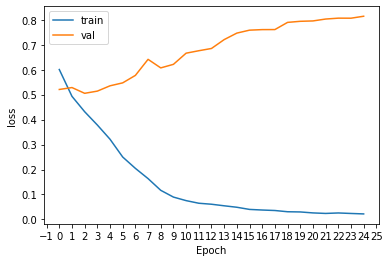

<Figure size 432x288 with 0 Axes>

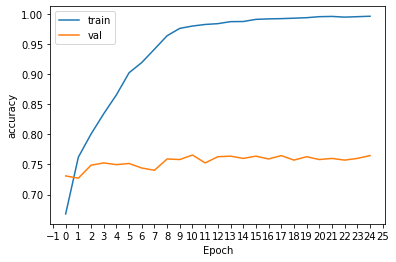

In [11]:
Train.train(input_train_tensors=x_train_tensors, output_train_tensors=y_train_tensors, 
            input_val_tensors=x_test_tensors, output_val_tensors=y_test_tensors,
            model=model, epoches=100, batch_size=50, print_every=1, plot_every=1, learning_rate=0.001,
           patience = 5, early_stop=20)